In [1]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.8 MB/s eta 0:00:00


In [23]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import pandas as pd
from google.colab import drive
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split
import shap

In [3]:
drive.mount("/content/drive")


Mounted at /content/drive


In [4]:
!unzip /content/drive/MyDrive/credit_scoring_data/home-credit-default-risk.zip -d /content/data

Archive:  /content/drive/MyDrive/credit_scoring_data/home-credit-default-risk.zip
  inflating: /content/data/HomeCredit_columns_description.csv  
  inflating: /content/data/POS_CASH_balance.csv  
  inflating: /content/data/application_test.csv  
  inflating: /content/data/application_train.csv  
  inflating: /content/data/bureau.csv  
  inflating: /content/data/bureau_balance.csv  
  inflating: /content/data/credit_card_balance.csv  
  inflating: /content/data/installments_payments.csv  
  inflating: /content/data/previous_application.csv  
  inflating: /content/data/sample_submission.csv  


# EDA

In [5]:
app = pd.read_csv('/content/data/application_train.csv')
bureau = pd.read_csv('/content/data/bureau.csv')
bur_balance = pd.read_csv('/content/data/bureau_balance.csv')
credit_card_balance = pd.read_csv('/content/data/credit_card_balance.csv')
installments_payments = pd.read_csv('/content/data/installments_payments.csv')
prev_app = pd.read_csv('/content/data/previous_application.csv')
pos_cash_balance = pd.read_csv('/content/data/POS_CASH_balance.csv')



In [6]:
old_app = app.copy()
old_bureau = bureau.copy()
app.columns.tolist()

['SK_ID_CURR',
 'TARGET',
 'NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'NAME_TYPE_SUITE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'REGION_POPULATION_RELATIVE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'OWN_CAR_AGE',
 'FLAG_MOBIL',
 'FLAG_EMP_PHONE',
 'FLAG_WORK_PHONE',
 'FLAG_CONT_MOBILE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'OCCUPATION_TYPE',
 'CNT_FAM_MEMBERS',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'WEEKDAY_APPR_PROCESS_START',
 'HOUR_APPR_PROCESS_START',
 'REG_REGION_NOT_LIVE_REGION',
 'REG_REGION_NOT_WORK_REGION',
 'LIVE_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'LIVE_CITY_NOT_WORK_CITY',
 'ORGANIZATION_TYPE',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'APARTMENTS_AVG',
 'BASEMENTAREA_AVG',
 'YEARS_BEGINEXPLUATATION_A

In [ ]:
bureau.columns.tolist()

['SK_ID_CURR',
 'SK_ID_BUREAU',
 'CREDIT_ACTIVE',
 'CREDIT_CURRENCY',
 'DAYS_CREDIT',
 'CREDIT_DAY_OVERDUE',
 'DAYS_CREDIT_ENDDATE',
 'DAYS_ENDDATE_FACT',
 'AMT_CREDIT_MAX_OVERDUE',
 'CNT_CREDIT_PROLONG',
 'AMT_CREDIT_SUM',
 'AMT_CREDIT_SUM_DEBT',
 'AMT_CREDIT_SUM_LIMIT',
 'AMT_CREDIT_SUM_OVERDUE',
 'CREDIT_TYPE',
 'DAYS_CREDIT_UPDATE',
 'AMT_ANNUITY']

In [7]:
na_cnt = app.isna().sum()
na_pct = na_cnt / len(app) * 100
miss = pd.DataFrame({
    'na_count': na_cnt,
    'na_pct': na_pct
}).sort_values('na_pct', ascending=False)
miss

,na_count,na_pct
COMMONAREA_AVG,214865,69.872297
COMMONAREA_MODE,214865,69.872297
COMMONAREA_MEDI,214865,69.872297
NONLIVINGAPARTMENTS_MEDI,213514,69.432963
NONLIVINGAPARTMENTS_MODE,213514,69.432963
...,...,...
FLAG_DOCUMENT_16,0,0.000000
FLAG_DOCUMENT_15,0,0.000000
FLAG_DOCUMENT_14,0,0.000000
FLAG_DOCUMENT_20,0,0.000000


In [8]:
train_ids = app['SK_ID_CURR']

# список колонок на удаление
drop_cols = [

    # ID
    'SK_ID_CURR',

    # COMMONAREA
    'COMMONAREA_AVG', 'COMMONAREA_MODE', 'COMMONAREA_MEDI',

    # NONLIVING APARTMENTS
    'NONLIVINGAPARTMENTS_AVG',
    'NONLIVINGAPARTMENTS_MODE',
    'NONLIVINGAPARTMENTS_MEDI',

    # NONLIVING AREA
    'NONLIVINGAREA_AVG',
    'NONLIVINGAREA_MODE',
    'NONLIVINGAREA_MEDI',

    # LAND AREA
    'LANDAREA_AVG',
    'LANDAREA_MODE',
    'LANDAREA_MEDI',

    # BASEMENT
    'BASEMENTAREA_AVG',
    'BASEMENTAREA_MODE',
    'BASEMENTAREA_MEDI',

    # LIVING APARTMENTS
    'LIVINGAPARTMENTS_AVG',
    'LIVINGAPARTMENTS_MODE',
    'LIVINGAPARTMENTS_MEDI',

    # FLOORS MIN
    'FLOORSMIN_AVG',
    'FLOORSMIN_MODE',
    'FLOORSMIN_MEDI',

    # FLOORS MAX (убираем по твоему решению)
    'FLOORSMAX_AVG',
    'FLOORSMAX_MODE',
    'FLOORSMAX_MEDI',

    # ENTRANCES
    'ENTRANCES_AVG',
    'ENTRANCES_MODE',
    'ENTRANCES_MEDI',

    # YEARS
    'YEARS_BUILD_AVG',
    'YEARS_BUILD_MODE',
    'YEARS_BUILD_MEDI',

    'YEARS_BEGINEXPLUATATION_AVG',
    'YEARS_BEGINEXPLUATATION_MODE',
    'YEARS_BEGINEXPLUATATION_MEDI',
    'OWN_CAR_AGE',
    # OTHER HOUSING
    'FONDKAPREMONT_MODE',
    'HOUSETYPE_MODE',
    'WALLSMATERIAL_MODE',
    'EMERGENCYSTATE_MODE',

    # AREA SUMMARY
    'TOTALAREA_MODE',

    # LIFTS
    'ELEVATORS_AVG',
    'ELEVATORS_MODE',
    'ELEVATORS_MEDI'
]

# удаляем (errors='ignore' — чтобы не падало, если колонки нет)
app = app.drop(columns=drop_cols, errors='ignore')
app.columns.tolist()

['TARGET',
 'NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'NAME_TYPE_SUITE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'REGION_POPULATION_RELATIVE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'FLAG_MOBIL',
 'FLAG_EMP_PHONE',
 'FLAG_WORK_PHONE',
 'FLAG_CONT_MOBILE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'OCCUPATION_TYPE',
 'CNT_FAM_MEMBERS',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'WEEKDAY_APPR_PROCESS_START',
 'HOUR_APPR_PROCESS_START',
 'REG_REGION_NOT_LIVE_REGION',
 'REG_REGION_NOT_WORK_REGION',
 'LIVE_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'LIVE_CITY_NOT_WORK_CITY',
 'ORGANIZATION_TYPE',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'APARTMENTS_AVG',
 'LIVINGAREA_AVG',
 'APARTMENTS_MODE',
 'LIVINGAREA_MODE',
 'APARTMENTS_MEDI',


In [ ]:
app.columns.tolist()

['TARGET',
 'NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'NAME_TYPE_SUITE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'REGION_POPULATION_RELATIVE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'OWN_CAR_AGE',
 'FLAG_MOBIL',
 'FLAG_EMP_PHONE',
 'FLAG_WORK_PHONE',
 'FLAG_CONT_MOBILE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'OCCUPATION_TYPE',
 'CNT_FAM_MEMBERS',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'WEEKDAY_APPR_PROCESS_START',
 'HOUR_APPR_PROCESS_START',
 'REG_REGION_NOT_LIVE_REGION',
 'REG_REGION_NOT_WORK_REGION',
 'LIVE_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'LIVE_CITY_NOT_WORK_CITY',
 'ORGANIZATION_TYPE',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'APARTMENTS_AVG',
 'LIVINGAREA_AVG',
 'APARTMENTS_MODE',
 'LIVINGAREA_MODE',
 'AP

In [11]:
corr = app.corr(numeric_only=True)
pd.set_option('display.max_rows', None)
display(corr['TARGET'].sort_values(ascending=False))

,TARGET
TARGET,1.000000
DAYS_BIRTH,0.078239
REGION_RATING_CLIENT_W_CITY,0.060893
REGION_RATING_CLIENT,0.058899
DAYS_LAST_PHONE_CHANGE,0.055218
DAYS_ID_PUBLISH,0.051457
REG_CITY_NOT_WORK_CITY,0.050994
FLAG_EMP_PHONE,0.045982
REG_CITY_NOT_LIVE_CITY,0.044395
FLAG_DOCUMENT_3,0.044346


In [9]:
drop_simple_flags = [
    'FLAG_MOBIL',
    'FLAG_CONT_MOBILE',
]

doc_cols = [c for c in app.columns if c.startswith('FLAG_DOCUMENT_')]

doc_cols_to_drop = [c for c in doc_cols if c != 'FLAG_DOCUMENT_3']

drop_cols = drop_simple_flags + doc_cols_to_drop

app = app.drop(columns=drop_cols, errors='ignore')

In [12]:
corr_abs = corr.abs()
high_corr = corr_abs.where(
    np.triu(np.ones(corr_abs.shape), k=1).astype(bool)
).stack().sort_values(ascending=False)
high_corr

,,0
DAYS_EMPLOYED,FLAG_EMP_PHONE,0.999755
OBS_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,0.998490
LIVINGAREA_AVG,LIVINGAREA_MEDI,0.995596
APARTMENTS_AVG,APARTMENTS_MEDI,0.995081
AMT_CREDIT,AMT_GOODS_PRICE,0.986968
APARTMENTS_MODE,APARTMENTS_MEDI,0.977193
LIVINGAREA_MODE,LIVINGAREA_MEDI,0.974743
APARTMENTS_AVG,APARTMENTS_MODE,0.973259
LIVINGAREA_AVG,LIVINGAREA_MODE,0.972050
REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,0.950842


In [13]:
drop_high_corr_columns = ['OBS_60_CNT_SOCIAL_CIRCLE', 'LIVINGAREA_MEDI',
                          'APARTMENTS_MEDI', 'AMT_GOODS_PRICE', 'APARTMENTS_MODE',
                          'LIVINGAREA_MODE', 'REGION_RATING_CLIENT', 'LIVINGAREA_AVG',
                          'CNT_CHILDREN', 'DEF_60_CNT_SOCIAL_CIRCLE', 'LIVE_REGION_NOT_WORK_REGION',
                          'LIVE_CITY_NOT_WORK_CITY']
app = app.drop(columns=drop_high_corr_columns, errors='ignore')
app.columns.tolist()


['TARGET',
 'NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'NAME_TYPE_SUITE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'REGION_POPULATION_RELATIVE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'FLAG_EMP_PHONE',
 'FLAG_WORK_PHONE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'OCCUPATION_TYPE',
 'CNT_FAM_MEMBERS',
 'REGION_RATING_CLIENT_W_CITY',
 'WEEKDAY_APPR_PROCESS_START',
 'HOUR_APPR_PROCESS_START',
 'REG_REGION_NOT_LIVE_REGION',
 'REG_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'ORGANIZATION_TYPE',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'APARTMENTS_AVG',
 'OBS_30_CNT_SOCIAL_CIRCLE',
 'DEF_30_CNT_SOCIAL_CIRCLE',
 'DAYS_LAST_PHONE_CHANGE',
 'FLAG_DOCUMENT_3',
 'AMT_REQ_CREDIT_BUREAU_HOUR',
 'AMT_REQ_CREDIT_BUREAU_DAY',
 'AMT_REQ_CREDIT_BUREAU_WEEK',
 'AMT_REQ_CREDIT_BUREAU_MON',
 'AMT_REQ_

In [14]:
drop_useless_cols = ['AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK',
                     'FLAG_EMAIL', 'FLAG_WORK_PHONE', 'FLAG_PHONE', 'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION',
                     'REG_REGION_NOT_WORK_REGION']
app = app.drop(columns=drop_useless_cols, errors='ignore')
app.columns.tolist()
pd.set_option('display.max_columns', None)
app.head(10)

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_EMP_PHONE,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_3,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,1,Cash loans,M,N,Y,202500.0,406597.5,24700.5,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,1,Laborers,1.0,2,WEDNESDAY,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,2.0,2.0,-1134.0,1,0.0,0.0,1.0
1,0,Cash loans,F,N,N,270000.0,1293502.5,35698.5,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,1,Core staff,2.0,1,MONDAY,0,0,School,0.311267,0.622246,NaN,0.0959,1.0,0.0,-828.0,1,0.0,0.0,0.0
2,0,Revolving loans,M,Y,Y,67500.0,135000.0,6750.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,1,Laborers,1.0,2,MONDAY,0,0,Government,NaN,0.555912,0.729567,NaN,0.0,0.0,-815.0,0,0.0,0.0,0.0
3,0,Cash loans,F,N,Y,135000.0,312682.5,29686.5,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,0.008019,-19005,-3039,-9833.0,-2437,1,Laborers,2.0,2,WEDNESDAY,0,0,Business Entity Type 3,NaN,0.650442,NaN,NaN,2.0,0.0,-617.0,1,NaN,NaN,NaN
4,0,Cash loans,M,N,Y,121500.0,513000.0,21865.5,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.028663,-19932,-3038,-4311.0,-3458,1,Core staff,1.0,2,THURSDAY,0,1,Religion,NaN,0.322738,NaN,NaN,0.0,0.0,-1106.0,0,0.0,0.0,0.0
5,0,Cash loans,M,N,Y,99000.0,490495.5,27517.5,"Spouse, partner",State servant,Secondary / secondary special,Married,House / apartment,0.035792,-16941,-1588,-4970.0,-477,1,Laborers,2.0,2,WEDNESDAY,0,0,Other,NaN,0.354225,0.621226,NaN,0.0,0.0,-2536.0,1,0.0,1.0,1.0
6,0,Cash loans,F,Y,Y,171000.0,1560726.0,41301.0,Unaccompanied,Commercial associate,Higher education,Married,House / apartment,0.035792,-13778,-3130,-1213.0,-619,1,Accountants,3.0,2,SUNDAY,0,0,Business Entity Type 3,0.774761,0.724000,0.492060,NaN,1.0,0.0,-1562.0,0,1.0,1.0,2.0
7,0,Cash loans,M,Y,Y,360000.0,1530000.0,42075.0,Unaccompanied,State servant,Higher education,Married,House / apartment,0.003122,-18850,-449,-4597.0,-2379,1,Managers,2.0,3,MONDAY,0,1,Other,NaN,0.714279,0.540654,NaN,2.0,0.0,-1070.0,1,0.0,0.0,0.0
8,0,Cash loans,F,N,Y,112500.0,1019610.0,33826.5,Children,Pensioner,Secondary / secondary special,Married,House / apartment,0.018634,-20099,365243,-7427.0,-3514,0,NaN,2.0,2,WEDNESDAY,0,0,XNA,0.587334,0.205747,0.751724,NaN,1.0,0.0,0.0,1,0.0,0.0,1.0
9,0,Revolving loans,M,N,Y,135000.0,405000.0,20250.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.019689,-14469,-2019,-14437.0,-3992,1,Laborers,1.0,2,THURSDAY,0,0,Electricity,NaN,0.746644,NaN,NaN,2.0,0.0,-1673.0,0,NaN,NaN,NaN


In [15]:
app['DAYS_EMPLOYED'] = app['DAYS_EMPLOYED'].replace(365243, np.nan)
app['CREDIT_TO_INCOME'] = app['AMT_CREDIT'] / app['AMT_INCOME_TOTAL']
app['ANNUITY_TO_INCOME'] = app['AMT_ANNUITY'] / app['AMT_INCOME_TOTAL']

In [ ]:
X = app.drop(columns=['TARGET'])
y = app['TARGET']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
cat_features = ['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_TYPE_SUITE',
                'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE',
                'OCCUPATION_TYPE', 'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE']
X_train[cat_features] = X_train[cat_features].fillna('__MISSING__')
X_val[cat_features]   = X_val[cat_features].fillna('__MISSING__')
train_pool = Pool(X_train, y_train, cat_features=cat_features)
val_pool = Pool(X_val, y_val, cat_features=cat_features)
model = CatBoostClassifier(iterations=1000,
                           learning_rate=0.05,
                           max_depth=6,
                           loss_function='Logloss',
                           early_stopping_rounds=200,
                           eval_metric='AUC',
                           verbose=200)
model.fit(train_pool, eval_set=val_pool, use_best_model=True)


0:	test: 0.6282298	best: 0.6282298 (0)	total: 758ms	remaining: 12m 36s


KeyboardInterrupt: 

In [16]:
imp = model.get_feature_importance(type="PredictionValuesChange")
feat_imp = pd.Series(data=imp, index=X_train.columns).sort_values(ascending=False)
feat_imp

NameError: name 'model' is not defined

In [108]:
test_app = pd.read_csv('/content/data/application_test.csv')
def transform_app_like_train(df: pd.DataFrame) -> pd.DataFrame:

    df = df.copy()
    DROP_COLS_STATIC = [

        # ID
        'SK_ID_CURR',

        # COMMONAREA
        'COMMONAREA_AVG', 'COMMONAREA_MODE', 'COMMONAREA_MEDI',

        # NONLIVING APARTMENTS
        'NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAPARTMENTS_MEDI',

        # NONLIVING AREA
        'NONLIVINGAREA_AVG', 'NONLIVINGAREA_MODE', 'NONLIVINGAREA_MEDI',

        # LAND AREA
        'LANDAREA_AVG', 'LANDAREA_MODE', 'LANDAREA_MEDI',

        # BASEMENT
        'BASEMENTAREA_AVG', 'BASEMENTAREA_MODE', 'BASEMENTAREA_MEDI',

        # LIVING APARTMENTS
        'LIVINGAPARTMENTS_AVG', 'LIVINGAPARTMENTS_MODE', 'LIVINGAPARTMENTS_MEDI',

        # FLOORS MIN
        'FLOORSMIN_AVG', 'FLOORSMIN_MODE', 'FLOORSMIN_MEDI',

        # FLOORS MAX
        'FLOORSMAX_AVG', 'FLOORSMAX_MODE', 'FLOORSMAX_MEDI',

        # ENTRANCES
        'ENTRANCES_AVG', 'ENTRANCES_MODE', 'ENTRANCES_MEDI',

        # YEARS
        'YEARS_BUILD_AVG', 'YEARS_BUILD_MODE', 'YEARS_BUILD_MEDI',

        'YEARS_BEGINEXPLUATATION_AVG',
        'YEARS_BEGINEXPLUATATION_MODE',
        'YEARS_BEGINEXPLUATATION_MEDI',

        'OWN_CAR_AGE',

        # HOUSING
        'FONDKAPREMONT_MODE',
        'HOUSETYPE_MODE',
        'WALLSMATERIAL_MODE',
        'EMERGENCYSTATE_MODE',

        # AREA
        'TOTALAREA_MODE',

        # LIFTS
        'ELEVATORS_AVG', 'ELEVATORS_MODE', 'ELEVATORS_MEDI',

        # SIMPLE FLAGS
        'FLAG_MOBIL',
        'FLAG_CONT_MOBILE',

        # HIGH CORR
        'OBS_60_CNT_SOCIAL_CIRCLE',
        'LIVINGAREA_MEDI',
        'APARTMENTS_MEDI',
        'AMT_GOODS_PRICE',
        'APARTMENTS_MODE',
        'LIVINGAREA_MODE',
        'REGION_RATING_CLIENT',
        'LIVINGAREA_AVG',
        'CNT_CHILDREN',
        'DEF_60_CNT_SOCIAL_CIRCLE',
        'LIVE_REGION_NOT_WORK_REGION',
        'LIVE_CITY_NOT_WORK_CITY',

        # USELESS
        'AMT_REQ_CREDIT_BUREAU_HOUR',
        'AMT_REQ_CREDIT_BUREAU_DAY',
        'AMT_REQ_CREDIT_BUREAU_WEEK',
        'FLAG_EMAIL',
        'FLAG_WORK_PHONE',
        'FLAG_PHONE',
        'HOUR_APPR_PROCESS_START',
        'REG_REGION_NOT_LIVE_REGION',
        'REG_REGION_NOT_WORK_REGION',
    ]


    # --- 1. основной drop ---
    df = df.drop(columns=DROP_COLS_STATIC, errors="ignore")

    # --- 2. FLAG_DOCUMENT_* (оставляем только 3) ---
    doc_cols = [c for c in df.columns if c.startswith("FLAG_DOCUMENT_")]
    doc_cols_to_drop = [c for c in doc_cols if c != "FLAG_DOCUMENT_3"]

    df = df.drop(columns=doc_cols_to_drop, errors="ignore")

    # --- 3. feature engineering ---

    if "DAYS_EMPLOYED" in df.columns:
        df["DAYS_EMPLOYED"] = df["DAYS_EMPLOYED"].replace(365243, np.nan)

    if {"AMT_CREDIT", "AMT_INCOME_TOTAL"}.issubset(df.columns):
        denom = df["AMT_INCOME_TOTAL"].replace(0, np.nan)
        df["CREDIT_TO_INCOME"] = df["AMT_CREDIT"] / denom

    if {"AMT_ANNUITY", "AMT_INCOME_TOTAL"}.issubset(df.columns):
        denom = df["AMT_INCOME_TOTAL"].replace(0, np.nan)
        df["ANNUITY_TO_INCOME"] = df["AMT_ANNUITY"] / denom

    # --- 4. убрать TARGET ---
    if "TARGET" in df.columns:
        df = df.drop(columns=["TARGET"])

    return df
test_ID_CURR = test_app['SK_ID_CURR']
X_test = transform_app_like_train(test_app)
# X_test[cat_features] = X_test[cat_features].fillna('__MISSING__')
# test_pool = Pool(X_test, cat_features=cat_features)
# y_test = model.predict_proba(test_pool)[:, 1]
# submission = pd.DataFrame({
#     "SK_ID_CURR": test_ID_CURR,
#     "TARGET": y_test
# })
# submission.to_csv("submission.csv", index=False)


In [17]:
bureau.head(20)

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.00,0.00,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.00,171342.00,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.50,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.00,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.00,NaN,NaN,0.0,Consumer credit,-21,NaN
5,215354,5714467,Active,currency 1,-273,0,27460.0,NaN,0.0,0,180000.00,71017.38,108982.62,0.0,Credit card,-31,NaN
6,215354,5714468,Active,currency 1,-43,0,79.0,NaN,0.0,0,42103.80,42103.80,0.00,0.0,Consumer credit,-22,NaN
7,162297,5714469,Closed,currency 1,-1896,0,-1684.0,-1710.0,14985.0,0,76878.45,0.00,0.00,0.0,Consumer credit,-1710,NaN
8,162297,5714470,Closed,currency 1,-1146,0,-811.0,-840.0,0.0,0,103007.70,0.00,0.00,0.0,Consumer credit,-840,NaN
9,162297,5714471,Active,currency 1,-1146,0,-484.0,NaN,0.0,0,4500.00,0.00,0.00,0.0,Credit card,-690,NaN


In [93]:
bureau_agg = (bureau.groupby(['SK_ID_CURR']).agg(
    BUREAU_CNT=("SK_ID_BUREAU", "count"),
    BUREAU_DAYS_CREDIT_MAX=("DAYS_CREDIT", "max"),
    BUREAU_DAYS_CREDIT_AVG=("DAYS_CREDIT", "mean"),
    BUREAU_CREDIT_DAY_OVERDUE_MAX=("CREDIT_DAY_OVERDUE", "max"),
    BUREAU_AMT_CREDIT_SUM_OVERDUE_SUM=("AMT_CREDIT_SUM_OVERDUE", "sum"),
    BUREAU_CNT_CREDIT_PROLONG_SUM=("CNT_CREDIT_PROLONG", "sum"),
    BUREAU_AMT_CREDIT_SUM_DEBT_MAX = ("AMT_CREDIT_SUM_DEBT", "max"),
    BUREAU_AMT_CREDIT_SUM_DEBT_SUM = ("AMT_CREDIT_SUM_DEBT", "sum"),
    BUREAU_AMT_CREDIT_SUM_SUM = ("AMT_CREDIT_SUM", "sum")
))
bureau_agg.head(20)

,BUREAU_CNT,BUREAU_DAYS_CREDIT_MAX,BUREAU_DAYS_CREDIT_AVG,BUREAU_CREDIT_DAY_OVERDUE_MAX,BUREAU_AMT_CREDIT_SUM_OVERDUE_SUM,BUREAU_CNT_CREDIT_PROLONG_SUM,BUREAU_AMT_CREDIT_SUM_DEBT_MAX,BUREAU_AMT_CREDIT_SUM_DEBT_SUM,BUREAU_AMT_CREDIT_SUM_SUM
SK_ID_CURR,,,,,,,,,
100001,7,-49,-735.000000,0,0.0,0,373239.00,596686.50,1453365.000
100002,8,-103,-874.000000,0,0.0,0,245781.00,245781.00,865055.565
100003,4,-606,-1400.750000,0,0.0,0,0.00,0.00,1017400.500
100004,2,-408,-867.000000,0,0.0,0,0.00,0.00,189037.800
100005,3,-62,-190.666667,0,0.0,0,543087.00,568408.50,657126.000
100007,1,-1149,-1149.000000,0,0.0,0,0.00,0.00,146250.000
100008,3,-78,-757.333333,0,0.0,0,240057.00,240057.00,468445.500
100009,18,-239,-1271.500000,0,0.0,0,557959.50,1077349.50,4800811.500
100010,2,-1138,-1939.500000,0,0.0,0,348007.50,348007.50,990000.000


In [94]:
bureau_credit_status_cnt = pd.crosstab(bureau["SK_ID_CURR"], bureau["CREDIT_ACTIVE"]).reset_index()
bureau_credit_status_cnt = bureau_credit_status_cnt.rename(columns={
    "Active": "BUREAU_ACTIVE_CNT",
    "Closed": "BUREAU_CLOSED_CNT",
    "Sold": "BUREAU_SOLD_CNT",
    "Bad debt": "BUREAU_BAD_DEBT_CNT"
})
bureau_agg = bureau_agg.merge(bureau_credit_status_cnt, on="SK_ID_CURR", how="left")
bureau_agg.head(20)

,SK_ID_CURR,BUREAU_CNT,BUREAU_DAYS_CREDIT_MAX,BUREAU_DAYS_CREDIT_AVG,BUREAU_CREDIT_DAY_OVERDUE_MAX,BUREAU_AMT_CREDIT_SUM_OVERDUE_SUM,BUREAU_CNT_CREDIT_PROLONG_SUM,BUREAU_AMT_CREDIT_SUM_DEBT_MAX,BUREAU_AMT_CREDIT_SUM_DEBT_SUM,BUREAU_AMT_CREDIT_SUM_SUM,BUREAU_ACTIVE_CNT,BUREAU_BAD_DEBT_CNT,BUREAU_CLOSED_CNT,BUREAU_SOLD_CNT
0,100001,7,-49,-735.000000,0,0.0,0,373239.00,596686.50,1453365.000,3,0,4,0
1,100002,8,-103,-874.000000,0,0.0,0,245781.00,245781.00,865055.565,2,0,6,0
2,100003,4,-606,-1400.750000,0,0.0,0,0.00,0.00,1017400.500,1,0,3,0
3,100004,2,-408,-867.000000,0,0.0,0,0.00,0.00,189037.800,0,0,2,0
4,100005,3,-62,-190.666667,0,0.0,0,543087.00,568408.50,657126.000,2,0,1,0
5,100007,1,-1149,-1149.000000,0,0.0,0,0.00,0.00,146250.000,0,0,1,0
6,100008,3,-78,-757.333333,0,0.0,0,240057.00,240057.00,468445.500,1,0,2,0
7,100009,18,-239,-1271.500000,0,0.0,0,557959.50,1077349.50,4800811.500,4,0,14,0
8,100010,2,-1138,-1939.500000,0,0.0,0,348007.50,348007.50,990000.000,1,0,1,0
9,100011,4,-1309,-1773.000000,0,0.0,0,0.00,0.00,435228.300,0,0,4,0


In [20]:
na_cnt = bureau.isna().sum()
na_pct = na_cnt / len(bureau) * 100
miss = pd.DataFrame({
    'na_count': na_cnt,
    'na_pct': na_pct
}).sort_values('na_pct', ascending=False)
miss

,na_count,na_pct
AMT_ANNUITY,1226791,71.473490
AMT_CREDIT_MAX_OVERDUE,1124488,65.513264
DAYS_ENDDATE_FACT,633653,36.916958
AMT_CREDIT_SUM_LIMIT,591780,34.477415
AMT_CREDIT_SUM_DEBT,257669,15.011932
DAYS_CREDIT_ENDDATE,105553,6.149573
AMT_CREDIT_SUM,13,0.000757
SK_ID_CURR,0,0.000000
SK_ID_BUREAU,0,0.000000
CREDIT_DAY_OVERDUE,0,0.000000


In [21]:
app["SK_ID_CURR"] = train_ids
extended_app = app.merge(bureau_agg, on="SK_ID_CURR", how="left")
app = app.drop(columns=["SK_ID_CURR"], errors='ignore')
target = extended_app["TARGET"]
extended_app = extended_app.drop(columns=["SK_ID_CURR", "TARGET"], errors='ignore')
extended_app.head(20)

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_EMP_PHONE,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_3,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,CREDIT_TO_INCOME,ANNUITY_TO_INCOME,BUREAU_CNT,BUREAU_DAYS_CREDIT_MAX,BUREAU_DAYS_CREDIT_AVG,BUREAU_CREDIT_DAY_OVERDUE_MAX,BUREAU_AMT_CREDIT_SUM_OVERDUE_SUM,BUREAU_CNT_CREDIT_PROLONG_SUM,BUREAU_AMT_CREDIT_SUM_DEBT_MAX,BUREAU_AMT_CREDIT_SUM_DEBT_SUM,BUREAU_AMT_CREDIT_SUM_SUM,BUREAU_ACTIVE_CNT,BUREAU_BAD_DEBT_CNT,BUREAU_CLOSED_CNT,BUREAU_SOLD_CNT
0,Cash loans,M,N,Y,202500.000,406597.5,24700.5,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637.0,-3648.0,-2120,1,Laborers,1.0,2,WEDNESDAY,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,2.0,2.0,-1134.0,1,0.0,0.0,1.0,2.007889,0.121978,8.0,-103.0,-874.000000,0.0,0.0,0.0,245781.00,245781.00,865055.565,2.0,0.0,6.0,0.0
1,Cash loans,F,N,N,270000.000,1293502.5,35698.5,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188.0,-1186.0,-291,1,Core staff,2.0,1,MONDAY,0,0,School,0.311267,0.622246,NaN,0.0959,1.0,0.0,-828.0,1,0.0,0.0,0.0,4.790750,0.132217,4.0,-606.0,-1400.750000,0.0,0.0,0.0,0.00,0.00,1017400.500,1.0,0.0,3.0,0.0
2,Revolving loans,M,Y,Y,67500.000,135000.0,6750.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225.0,-4260.0,-2531,1,Laborers,1.0,2,MONDAY,0,0,Government,NaN,0.555912,0.729567,NaN,0.0,0.0,-815.0,0,0.0,0.0,0.0,2.000000,0.100000,2.0,-408.0,-867.000000,0.0,0.0,0.0,0.00,0.00,189037.800,0.0,0.0,2.0,0.0
3,Cash loans,F,N,Y,135000.000,312682.5,29686.5,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,0.008019,-19005,-3039.0,-9833.0,-2437,1,Laborers,2.0,2,WEDNESDAY,0,0,Business Entity Type 3,NaN,0.650442,NaN,NaN,2.0,0.0,-617.0,1,NaN,NaN,NaN,2.316167,0.219900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Cash loans,M,N,Y,121500.000,513000.0,21865.5,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.028663,-19932,-3038.0,-4311.0,-3458,1,Core staff,1.0,2,THURSDAY,0,1,Religion,NaN,0.322738,NaN,NaN,0.0,0.0,-1106.0,0,0.0,0.0,0.0,4.222222,0.179963,1.0,-1149.0,-1149.000000,0.0,0.0,0.0,0.00,0.00,146250.000,0.0,0.0,1.0,0.0
5,Cash loans,M,N,Y,99000.000,490495.5,27517.5,"Spouse, partner",State servant,Secondary / secondary special,Married,House / apartment,0.035792,-16941,-1588.0,-4970.0,-477,1,Laborers,2.0,2,WEDNESDAY,0,0,Other,NaN,0.354225,0.621226,NaN,0.0,0.0,-2536.0,1,0.0,1.0,1.0,4.954500,0.277955,3.0,-78.0,-757.333333,0.0,0.0,0.0,240057.00,240057.00,468445.500,1.0,0.0,2.0,0.0
6,Cash loans,F,Y,Y,171000.000,1560726.0,41301.0,Unaccompanied,Commercial associate,Higher education,Married,House / apartment,0.035792,-13778,-3130.0,-1213.0,-619,1,Accountants,3.0,2,SUNDAY,0,0,Business Entity Type 3,0.774761,0.724000,0.492060,NaN,1.0,0.0,-1562.0,0,1.0,1.0,2.0,9.127053,0.241526,18.0,-239.0,-1271.500000,0.0,0.0,0.0,557959.50,1077349.50,4800811.500,4.0,0.0,14.0,0.0
7,Cash loans,M,Y,Y,360000.000,1530000.0,42075.0,Unaccompanied,State servant,Higher education,Married,House / apartment,0.003122,-18850,-449.0,-4597.0,-2379,1,Managers,2.0,3,MONDAY,0,1,Other,NaN,0.714279,0.540654,NaN,2.0,0.0,-1070.0,1,0.0,0.0,0.0,4.250000,0.116875,2.0,-1138.0,-1939.500000,0.0,0.0,0.0,348007.50,348007.50,990000.000,1.0,0.0,1.0,0.0
8,Cash loans,F,N,Y,112500.000,1019610.0,33826.5,Children,Pensioner,Secondary / secondary special,Marr

In [24]:
X = extended_app
y = target
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
cat_features = ['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_TYPE_SUITE',
                'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE',
                'OCCUPATION_TYPE', 'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE']
X_train[cat_features] = X_train[cat_features].fillna('__MISSING__')
X_val[cat_features]   = X_val[cat_features].fillna('__MISSING__')
train_pool = Pool(X_train, y_train, cat_features=cat_features)
val_pool = Pool(X_val, y_val, cat_features=cat_features)
model = CatBoostClassifier(iterations=1000,
                           learning_rate=0.05,
                           max_depth=7,
                           loss_function='Logloss',
                           early_stopping_rounds=200,
                           eval_metric='AUC',
                           verbose=200)
model.fit(train_pool, eval_set=val_pool, use_best_model=True)


0:	test: 0.6761481	best: 0.6761481 (0)	total: 861ms	remaining: 14m 20s
200:	test: 0.7571133	best: 0.7571272 (199)	total: 2m 53s	remaining: 11m 27s
400:	test: 0.7618099	best: 0.7618099 (400)	total: 5m 51s	remaining: 8m 45s
600:	test: 0.7634313	best: 0.7634406 (599)	total: 8m 45s	remaining: 5m 48s
800:	test: 0.7645205	best: 0.7645453 (798)	total: 11m 42s	remaining: 2m 54s
999:	test: 0.7648541	best: 0.7648541 (999)	total: 14m 44s	remaining: 0us

bestTest = 0.7648541025
bestIteration = 999



In [29]:
shap_values = model.get_feature_importance(
    data=val_pool,
    type="ShapValues"
)
shap_values = shap_values[:, :-1]
shap.summary_plot(shap_values, X_val)

NameError: name 'shap_vlaues' is not defined

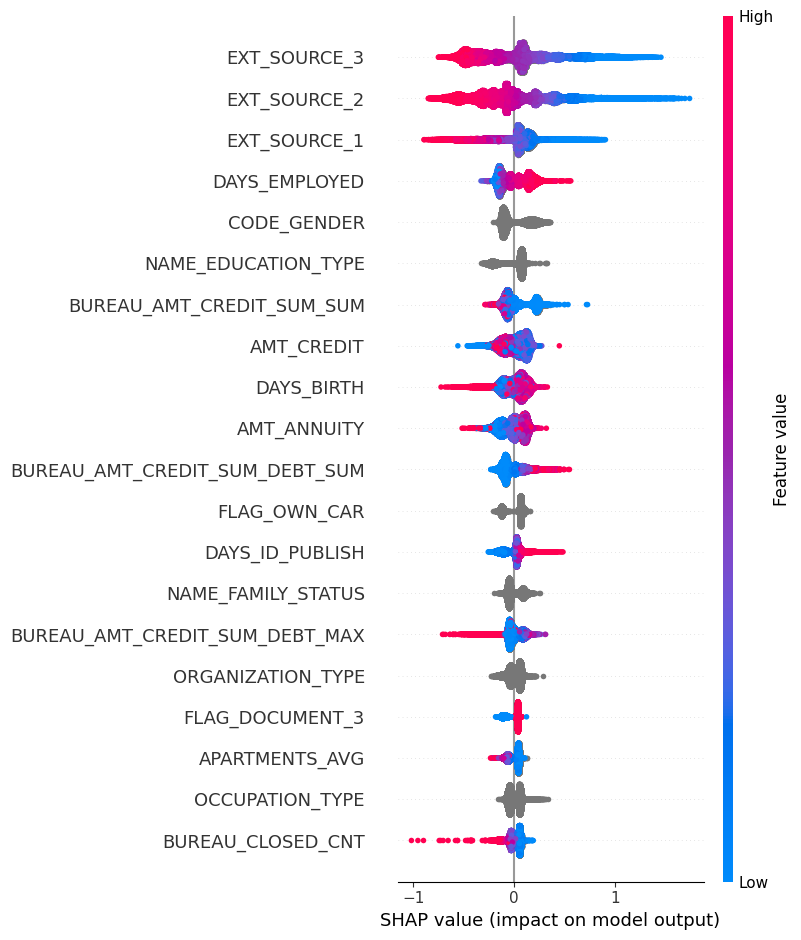

In [30]:
shap_values = shap_values[:, :-1]
shap.summary_plot(shap_values, X_val)

In [ ]:
X_test["SK_ID_CURR"] = test_ID_CURR
X_test = X_test.merge(bureau_agg, on="SK_ID_CURR", how="left")
X_test = X_test.drop(columns=["SK_ID_CURR"], errors='ignore')
X_test[cat_features] = X_test[cat_features].fillna('__MISSING__')
X_test.head(10)
test_pool = Pool(X_test, cat_features=cat_features)
y_test = model.predict_proba(test_pool)[:, 1]
submission = pd.DataFrame({
    "SK_ID_CURR": test_ID_CURR,
    "TARGET": y_test
})
submission.to_csv("submission.csv", index=False)


In [32]:
len(extended_app.columns)

51

In [39]:
prev_app.head(10)

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,Y,1,0.0,0.182832,0.867336,XAP,Approved,-73,Cash through the bank,XAP,NaN,Repeater,Mobile,POS,XNA,Country-wide,35,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-164,XNA,XAP,Unaccompanied,Repeater,XNA,Cash,x-sell,Contact center,-1,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-301,Cash through the bank,XAP,"Spouse, partner",Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,Y,1,NaN,NaN,NaN,XNA,Approved,-512,Cash through the bank,XAP,NaN,Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,Y,1,NaN,NaN,NaN,Repairs,Refused,-781,Cash through the bank,HC,NaN,Repeater,XNA,Cash,walk-in,Credit and cash offices,-1,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN
5,1383531,199383,Cash loans,23703.930,315000.0,340573.5,NaN,315000.0,SATURDAY,8,Y,1,NaN,NaN,NaN,Everyday expenses,Approved,-684,Cash through the bank,XAP,Family,Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,18.0,low_normal,Cash X-Sell: low,365243.0,-654.0,-144.0,-144.0,-137.0,1.0
6,2315218,175704,Cash loans,NaN,0.0,0.0,NaN,NaN,TUESDAY,11,Y,1,NaN,NaN,NaN,XNA,Canceled,-14,XNA,XAP,NaN,Repeater,XNA,XNA,XNA,Credit and cash offices,-1,XNA,NaN,XNA,Cash,NaN,NaN,NaN,NaN,NaN,NaN
7,1656711,296299,Cash loans,NaN,0.0,0.0,NaN,NaN,MONDAY,7,Y,1,NaN,NaN,NaN,XNA,Canceled,-21,XNA,XAP,NaN,Repeater,XNA,XNA,XNA,Credit and cash offices,-1,XNA,NaN,XNA,Cash,NaN,NaN,NaN,NaN,NaN,NaN
8,2367563,342292,Cash loans,NaN,0.0,0.0,NaN,NaN,MONDAY,15,Y,1,NaN,NaN,NaN,XNA,Canceled,-386,XNA,XAP,NaN,Repeater,XNA,XNA,XNA,Credit and cash offices,-1,XNA,NaN,XNA,Cash,NaN,NaN,NaN,NaN,NaN,NaN
9,2579447,334349,Cash loans,NaN,0.0,0.0,NaN,NaN,SATURDAY,15,Y,1,NaN,NaN,NaN,XNA,Canceled,-57,XNA,XAP,NaN,Repeater,XNA,XNA,XNA,Credit and cash offices,-1,XNA,NaN,XNA,Cash,NaN,NaN,NaN,NaN,NaN,NaN


In [85]:
prev_app_name_contract_status = pd.crosstab(prev_app["SK_ID_CURR"], prev_app["NAME_CONTRACT_STATUS"])
prev_app_name_contract_status = prev_app_name_contract_status.rename(columns={
    "Approved": "PREV_APP_APPROVED_CNT",
    "Refused": "PREV_APP_REFUSED_CNT",
    "Canceled": "PREV_APP_CANCELED_CNT",
    "Unused offer": "PREV_APP_UNUSED_OFFER_CNT"
})
prev_app_name_contract_status.head(10)

NAME_CONTRACT_STATUS,PREV_APP_APPROVED_CNT,PREV_APP_CANCELED_CNT,PREV_APP_REFUSED_CNT,PREV_APP_UNUSED_OFFER_CNT
SK_ID_CURR,,,,
100001,1,0,0,0
100002,1,0,0,0
100003,3,0,0,0
100004,1,0,0,0
100005,1,1,0,0
100006,5,3,1,0
100007,6,0,0,0
100008,4,1,0,0
100009,7,0,0,0


In [86]:
prev_app_name_contract_status["PREV_APP_TOTAL_CNT"] = (
    prev_app_name_contract_status[
        ["PREV_APP_APPROVED_CNT",
        "PREV_APP_REFUSED_CNT",
        "PREV_APP_CANCELED_CNT",
        "PREV_APP_UNUSED_OFFER_CNT"]
    ].sum(axis=1)
)
prev_app_name_contract_status["PREV_APP_APPROVED_RATE"] = prev_app_name_contract_status["PREV_APP_APPROVED_CNT"] / prev_app_name_contract_status["PREV_APP_TOTAL_CNT"]
prev_app_name_contract_status["PREV_APP_REFUSED_RATE"] = prev_app_name_contract_status["PREV_APP_REFUSED_CNT"] / prev_app_name_contract_status["PREV_APP_TOTAL_CNT"]
prev_app_name_contract_status = prev_app_name_contract_status.reset_index()
prev_app_name_contract_status.head(10)



NAME_CONTRACT_STATUS,SK_ID_CURR,PREV_APP_APPROVED_CNT,PREV_APP_CANCELED_CNT,PREV_APP_REFUSED_CNT,PREV_APP_UNUSED_OFFER_CNT,PREV_APP_TOTAL_CNT,PREV_APP_APPROVED_RATE,PREV_APP_REFUSED_RATE
0,100001,1,0,0,0,1,1.000000,0.000000
1,100002,1,0,0,0,1,1.000000,0.000000
2,100003,3,0,0,0,3,1.000000,0.000000
3,100004,1,0,0,0,1,1.000000,0.000000
4,100005,1,1,0,0,2,0.500000,0.000000
5,100006,5,3,1,0,9,0.555556,0.111111
6,100007,6,0,0,0,6,1.000000,0.000000
7,100008,4,1,0,0,5,0.800000,0.000000
8,100009,7,0,0,0,7,1.000000,0.000000
9,100010,1,0,0,0,1,1.000000,0.000000


In [87]:
prev_app["CREDIT_APP_RATIO"] = prev_app["AMT_CREDIT"] / prev_app["AMT_APPLICATION"]
prev_app["ANNUITY_CREDIT_RATIO"] = prev_app["AMT_ANNUITY"] / prev_app["AMT_CREDIT"]
prev_app_agg = (prev_app.groupby(['SK_ID_CURR']).agg(
    PREV_APP_CNT=("SK_ID_PREV", "count"),
    PREV_APP_AMT_CREDIT_SUM=("AMT_CREDIT", "sum"),
    PREV_APP_AMT_CREDIT_MAX=("AMT_CREDIT", "max"),
    PREV_APP_CREDIT_APP_RATIO_AVG=("CREDIT_APP_RATIO", "mean"),
    PREV_APP_ANNUITY_CREDIT_RATIO_AVG=("ANNUITY_CREDIT_RATIO", "mean"),
    PREV_APP_CNT_PAYMENT_AVG=("CNT_PAYMENT", "mean"),
    PREV_APP_LAST_DAYS_DECISION=("DAYS_DECISION", "max"),
    PREV_APP_ANNUITY_CREDIT_AVG=("AMT_ANNUITY", "mean")
)).reset_index()
prev_app_agg.head(10)

,SK_ID_CURR,PREV_APP_CNT,PREV_APP_AMT_CREDIT_SUM,PREV_APP_AMT_CREDIT_MAX,PREV_APP_CREDIT_APP_RATIO_AVG,PREV_APP_ANNUITY_CREDIT_RATIO_AVG,PREV_APP_CNT_PAYMENT_AVG,PREV_APP_LAST_DAYS_DECISION,PREV_APP_ANNUITY_CREDIT_AVG
0,100001,1,23787.0,23787.0,0.957782,0.166099,8.000000,-1740,3951.000000
1,100002,1,179055.0,179055.0,1.000000,0.051670,24.000000,-606,9251.775000
2,100003,3,1452573.0,1035882.0,1.057664,0.126383,10.000000,-746,56553.990000
3,100004,1,20106.0,20106.0,0.828021,0.266450,4.000000,-815,5357.250000
4,100005,2,40153.5,40153.5,0.899950,0.119870,12.000000,-315,4813.200000
5,100006,9,2625259.5,906615.0,1.012684,0.069304,23.000000,-181,23651.175000
6,100007,6,999832.5,284400.0,1.046356,0.090659,20.666667,-374,12278.805000
7,100008,5,813838.5,501975.0,0.978569,0.118055,14.000000,-82,15839.696250
8,100009,7,490963.5,98239.5,0.916226,0.155250,8.000000,-74,10051.412143
9,100010,1,260811.0,260811.0,1.055009,0.105300,10.000000,-1070,27463.410000


In [88]:
prev_app_agg = prev_app_agg.merge(prev_app_name_contract_status[["SK_ID_CURR", "PREV_APP_APPROVED_RATE", "PREV_APP_REFUSED_RATE"]], on="SK_ID_CURR", how="left")
len(prev_app_agg.columns)

11

In [100]:
app["SK_ID_CURR"] = train_ids
extended_app = app.merge(bureau_agg, on="SK_ID_CURR", how="left")
extended_app_v2 = extended_app.merge(prev_app_agg, on="SK_ID_CURR", how="left")
extended_app_v2.head(10)
extended_app_v2.columns.tolist()

['TARGET',
 'NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'NAME_TYPE_SUITE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'REGION_POPULATION_RELATIVE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'FLAG_EMP_PHONE',
 'OCCUPATION_TYPE',
 'CNT_FAM_MEMBERS',
 'REGION_RATING_CLIENT_W_CITY',
 'WEEKDAY_APPR_PROCESS_START',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'ORGANIZATION_TYPE',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'APARTMENTS_AVG',
 'OBS_30_CNT_SOCIAL_CIRCLE',
 'DEF_30_CNT_SOCIAL_CIRCLE',
 'DAYS_LAST_PHONE_CHANGE',
 'FLAG_DOCUMENT_3',
 'AMT_REQ_CREDIT_BUREAU_MON',
 'AMT_REQ_CREDIT_BUREAU_QRT',
 'AMT_REQ_CREDIT_BUREAU_YEAR',
 'CREDIT_TO_INCOME',
 'ANNUITY_TO_INCOME',
 'SK_ID_CURR',
 'BUREAU_CNT',
 'BUREAU_DAYS_CREDIT_MAX',
 'BUREAU_DAYS_CREDIT_AVG',
 'BUREAU_CREDIT_DAY_OVERDUE_MAX',
 'BUREAU_AMT_CREDIT_

In [106]:
target = extended_app_v2["TARGET"]
extended_app_v2 = extended_app_v2.drop(columns=["TARGET", "SK_ID_CURR"], errors='ignore')

KeyError: 'TARGET'

In [107]:
X = extended_app_v2
y = target
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
cat_features = ['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_TYPE_SUITE',
                'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE',
                'OCCUPATION_TYPE', 'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE']
X_train[cat_features] = X_train[cat_features].fillna('__MISSING__')
X_val[cat_features]   = X_val[cat_features].fillna('__MISSING__')
train_pool = Pool(X_train, y_train, cat_features=cat_features)
val_pool = Pool(X_val, y_val, cat_features=cat_features)
model = CatBoostClassifier(iterations=1000,
                           learning_rate=0.05,
                           max_depth=6,
                           loss_function='Logloss',
                           early_stopping_rounds=200,
                           eval_metric='AUC',
                           verbose=200)
model.fit(train_pool, eval_set=val_pool, use_best_model=True)


0:	test: 0.6263322	best: 0.6263322 (0)	total: 604ms	remaining: 10m 3s
200:	test: 0.7628276	best: 0.7628276 (200)	total: 2m 53s	remaining: 11m 27s
400:	test: 0.7689174	best: 0.7689174 (400)	total: 5m 26s	remaining: 8m 7s
600:	test: 0.7707992	best: 0.7707992 (600)	total: 7m 57s	remaining: 5m 16s
800:	test: 0.7718163	best: 0.7718203 (797)	total: 10m 32s	remaining: 2m 37s
999:	test: 0.7726025	best: 0.7726025 (999)	total: 13m 5s	remaining: 0us

bestTest = 0.7726024939
bestIteration = 999



In [109]:
X_test["SK_ID_CURR"] = test_ID_CURR
X_test = X_test.merge(bureau_agg, on="SK_ID_CURR", how="left")
X_test = X_test.merge(prev_app_agg, on="SK_ID_CURR", how="left")
X_test = X_test.drop(columns=["SK_ID_CURR"], errors='ignore')
X_test[cat_features] = X_test[cat_features].fillna('__MISSING__')
test_pool = Pool(X_test, cat_features=cat_features)
y_test = model.predict_proba(test_pool)[:, 1]
submission = pd.DataFrame({
    "SK_ID_CURR": test_ID_CURR,
    "TARGET": y_test
})
submission.to_csv("submission.csv", index=False)
